### Import libraries

In [98]:
import pandas as pd
import random
from time import sleep
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
%matplotlib inline
pp = pprint.PrettyPrinter(compact=True)

### Scrape link directory
Using BeautifulSoup, we'll scrape wildwinds.com/coins/ric/i.html for landing pages of coin subjects  in alphabetical order. As of 11/3/2023, wildwinds.com/robots.txt grants permission for webscraping requests, provided there is a delay of 30 seconds between each request, and that the webscraping software is not explicitly blacklisted.

In [99]:
with requests.get('https://www.wildwinds.com/coins/ric/i.html') as raw:
    soup = BeautifulSoup(raw.content, 'lxml')

### Parse html data for a clean list of ruler names

In [100]:
options = soup.find_all('option')
emperors_raw = [i.contents for i in options if i.attrs['value'] != ''][:-6]
emperors = []
for line in emperors_raw:
    for text in line:
        emperors.append(text.strip())
print(f'First five: {emperors[:5]} \nLast five: {emperors[-5:]} \n{len(emperors)} emperors total')

First five: ['Aelia Ariadne', 'Aelia Flacilla', 'Aelia Verina', 'Aelius', 'Aemilian'] 
Last five: ['Vitellius', 'Volusian', 'Zeno', 'Zenobia', 'Zenonis'] 
231 emperors total


### Generate list of usable link roots for each Emperor's coin page

In [101]:
# wildwinds.com/robots.txt requires a 30-second delay between requests
linkroots = ['https://www.wildwinds.com/coins/ric/' + i.attrs['value'][:-6] for i in options if i.attrs['value'] != ''][:-6]
print(f'First five: {linkroots[:5]} \nLast five: {linkroots[-5:]} \n{len(linkroots)} linkroots total')

First five: ['https://www.wildwinds.com/coins/ric/aelia_ariadne/', 'https://www.wildwinds.com/coins/ric/aelia_flaccilla/', 'https://www.wildwinds.com/coins/ric/aelia_verina/', 'https://www.wildwinds.com/coins/ric/aelius/', 'https://www.wildwinds.com/coins/ric/aemilian/'] 
Last five: ['https://www.wildwinds.com/coins/ric/vitellius/', 'https://www.wildwinds.com/coins/ric/volusian/', 'https://www.wildwinds.com/coins/ric/zeno/', 'https://www.wildwinds.com/coins/ric/zenobia/', 'https://www.wildwinds.com/coins/ric/zenonis/'] 
231 linkroots total


### Create a semi-random list of test pages for building an adaptable parser

In [102]:
test_ids = random.choices(range(len(linkroots)), k=10) # 10 random index numbers
test_roots = [linkroots[i] for i in test_ids] # Corresponding url roots
for root in test_roots:
    print(root)

https://www.wildwinds.com/coins/ric/martinian/
https://www.wildwinds.com/coins/ric/theodora/
https://www.wildwinds.com/coins/ric/julius_nepos/
https://www.wildwinds.com/coins/ric/johannes/
https://www.wildwinds.com/coins/ric/lucilla/
https://www.wildwinds.com/coins/ric/bonosus/
https://www.wildwinds.com/coins/ric/jovinus/
https://www.wildwinds.com/coins/ric/aelia_ariadne/
https://www.wildwinds.com/coins/ric/pertinax/
https://www.wildwinds.com/coins/ric/paulina/


### pull html from test pages

In [103]:
# Define function that scrapes indicated pages with 30-second delay between requests
def scrape(url_roots: list[str]):
    combined_pages_html = []
    max_length = 0
    for root in url_roots:
        url = root + 'i.html'
        message = f'requesting {url} ({url_roots.index(root) + 1}/{len(url_roots)})'
        max_length = max(max_length, len(message))
        print(f'\r{message.ljust(max_length)}', end=' ', flush=True)
        sleep(30)
        page_html = requests.get(url)
        combined_pages_html.append(page_html)
    # After the loop, print a final message that clears the last line
    print(f'\rscraping complete: {url_roots.index(root) + 1}/{len(url_roots)}'.ljust(max_length))
    return combined_pages_html

In [104]:
# Scrape test pages' html (this takes some time with the delay)
test_pages = scrape(test_roots)

scraping complete: 10/10                                                   


### Inspect test page html

In [105]:
# Convert page html into easier-to-manipulate format using BeautifulSoup
test_soups = [BeautifulSoup(page.content, 'lxml') for page in test_pages]

In [106]:
print(f'Test soup preview: \n\n{str(test_soups[5])[:2000]}')

Test soup preview: 

<html>
<head>
<title>Bonosus, Roman Imperial Coins of, at WildWinds.com</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<base target="_parent"/>
</head>
<body bgcolor="#D7D5D5">
<object data="https://www.wildwinds.com/coins/topscript.html" height="160" width="100%"></object><br/>
<center>
<p></p><h2>Browsing Roman Imperial Coins of Bonosus</h2>
<p><img src="toppic.jpg"/>
<br/>Bonosus, of British descent and a general during Probus' reign, rebelled against the emperor and made himself emperor of Gaul. After a very brief reign he was defeated by Probus.

</p><h3><a href="t.html">Click here for the Bonosus page with thumbnail images.</a></h3>
<table border="1" cellpadding="0" cellspacing="1">
<tr><td bgcolor="#b87333">RIC 2cf</td><td>Bonosus, Usurper in Gaul ca.280 AD, AE Antoninianus.  [M] C BONO~SVS [///] on obv, radiate head of Bonosus showing bare neck right / ...AVG, uncertain deity standing, holding a long wavy object, perhaps Salus

### Create helper functions for parsing data fields

In [107]:
# Define function for parsing names of coin subjects
def pull_title(soup):
    raw_title = soup.find('title').text
    sep_index = raw_title.find(',')
    if sep_index == -1:
        sep_index = raw_title.find('-')
    return raw_title[:sep_index].strip() if sep_index != -1 else raw_title.strip()

In [108]:
# Function to test pull_title()
def test_pull_title(soups): 
    titles = pd.Series([pull_title(soup) for soup in soups])
    print(f'Out of {len(soups)} soups, {titles.isna().sum()} have missing titles.')
    pp.pprint(titles.tolist())

In [109]:
test_pull_title(test_soups)

Out of 10 soups, 0 have missing titles.
['Martinian', 'Theodora', 'Julius Nepos', 'Johannes', 'Lucilla', 'Bonosus',
 'Jovinus', 'Aelia Ariadne', 'Pertinax', 'Paulina']


In [110]:
# Function to pull subtitles
def pull_subtitle(soup):
    possible_locations = [
        lambda s: s.find_all('h3')[0].contents[-1],
        lambda s: s.find('font').contents[0],
        lambda s: s.find_all('p')[1].contents[-1],
        lambda s: s.find_all('br')[0].contents[0],
    ]
    
    for get_subtitle in possible_locations:
        try:
            subtitle = get_subtitle(soup)
            if not subtitle or len(str(subtitle)) < 4:
                continue
            if any(keyword in str(subtitle) for keyword in ['Click', 'Browse']):
                continue
            if '(' in str(subtitle) or '<' in str(subtitle):
                return None
            return str(subtitle).strip()
        except (IndexError, AttributeError):
            continue 
    
    return None

In [111]:
# Function to test pull_subtitle()
def test_pull_subtitle(soups):
    subtitles = pd.Series([pull_subtitle(soup) for soup in soups])
    print(f'Out of {len(soups)} soups, {subtitles.isna().sum()} are missing subtitles.')
    pp.pprint(subtitles.tolist()) 

In [112]:
test_pull_subtitle(test_soups)

Out of 10 soups, 5 are missing subtitles.
[None, None, None, 'Johannes, 423-425 AD.', None,
 "Bonosus, of British descent and a general during Probus' reign, rebelled "
 'against the emperor and made himself emperor of Gaul. After a very brief '
 'reign he was defeated by Probus.',
 'Note: For the VICTORIA.. reverse legend types, the legend break helps to '
 'pinpoint the reference number.',
 'Wife of Zeno and Anastasius, daughter of Leo I, mother of Leo II. Augusta '
 '474-474 and 477-491 AD.',
 None, 'Paulina, wife of Maximinus I']


In [113]:
# Function to pull raw coin data
def pull_coins(soup):
    coins = [coin.contents for coin in soup.find_all('tr') if len(coin) >2 and 'bgcolor' in str(coin)]
    return coins

In [114]:
# Test pull_coins
test_coins = pull_coins(test_soups[1])
print(f'{len(test_coins)} test coins. Raw data:\n')
pp.pprint(test_coins[:5])

20 test coins. Raw data:

[[<td bgcolor="#B87333">Aquileia<br/>RIC VII 123, Muled barb</td>,
  <td>Theodora barb. Unofficial mint, probably in England. Garbled legend ending in EA, draped bust right. / Victory with wings spread, standing left on prow, holding transverse sceptre and resting left hand on shield. Mintmark AQP. Muled barb with the reverse of RIC VII Aquileia 123; Sear 16460.</td>,
  <td><a href="_aquileia_RIC_123_barb_mule.txt">Text</a></td>,
  <td><a href="_aquileia_RIC_123_barb_mule.jpg">Image</a></td>],
 [<td bgcolor="#b87333"><font size="+1"><b> Constantinople</b></font> <center>RIC 36 </center></td>,
  <td>Theodora, AE follis. FL MAX THEO-DORAE AVG, bust right in plain mantle and necklace / PIETAS ROMANA dot, Pietas facing, head right, holding an infant; mintmark CONS epsilon. RIC VIII Constantinople 36; Sear 17505.</td>,
  <td><a href="_constantinople_RIC_036.txt">Text</a></td>,
  <td><a href="_constantinople_RIC_036.jpg">Image</a></td>],
 [<td bgcolor="#B87333">Cons

### Helper functions to parse useful data features

In [115]:
# Function to identify coin metal
def coin_metal(coin):
    metals = {'#B8':'Copper','#b8':'Copper', '#FF':'Gold', '#C0':'Silver', '#B7':'Brass', '#b7':'Brass', 'red':'FAKE'}
    coin = str(coin)
    try:
        bg_color_index = int(coin.find('bgcolor=')) + 9
        bg_color = coin[bg_color_index:bg_color_index + 3]
        metal = metals[bg_color]
    except:
        return None
    return metal

In [116]:
# Function to test previous function coin_metal()
def test_coin_metal(coins):
    metals = pd.Series([coin_metal(coin) for coin in coins])
    print(f'Out of {len(coins)} coins, {metals.isna().sum()} are missing metal value(s)')
    pp.pprint(metals.tolist())

In [117]:
test_coin_metal(test_coins)

Out of 20 coins, 0 are missing metal value(s)
['Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper',
 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper', 'Copper',
 'Copper', 'Copper', 'Copper', 'Copper']


In [118]:
# Function to pull coin era (i.e. 'AD' or 'BC') 
def coin_era(coin):
    match = re.search(r'\b(AD|BC)\b', str(coin))
    return match.group(0) if match else None

# Function to pull a year (not *every* year) in the coin description
# (if there is a range of years i.e. 117-124 AD, function pulls the year closest to era i.e. '117-124 AD' returns '124', while 'AD 117-124' returns '117')
def coin_year(coin):
    era = coin_era(coin)
    if not era:
        return None

    if era == 'AD':
        # Look for the year pattern before 'AD'
        match = re.search(r'(\d{1,4})(?=\s*AD)', str(coin))
    else:
        # Look for the year pattern before 'BC'
        match = re.search(r'(\d{1,4})(?=\s*BC)', str(coin))

    if not match:
        # If no year is found before the era, search after it
        match = re.search(r'(?<=\bAD\s)(\d{1,4})', str(coin)) if era == 'AD' else re.search(r'(?<=\bBC\s)(\d{1,4})', str(coin))

    if match:
        year = int(match.group(0))
        return year if era == 'AD' else -year
    else:
        return None

In [119]:
# Function to test coin_era() and coin_year()
def test_coin_era_and_year(coins):
    eras = [coin_era(coin) for coin in coins]
    years = [coin_year(coin) for coin in coins]
    df = pd.DataFrame({'eras':eras, 'years':years})
    print(f'Out of {len(coins)} coins:')
    print(f'{df.eras.isna().sum()} are missing era value(s).')
    print(f'{df.years.isna().sum()} are missing year value(s).')
    pp.pprint(eras)
    pp.pprint(years)

In [120]:
test_coin_era_and_year(test_coins)

Out of 20 coins:
2 are missing era value(s).
2 are missing year value(s).
[None, None, 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD',
 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD']
[None, None, 340, 337, 340, 340, 340, 340, 340, 340, 337, 340, 340, 340, 340,
 340, 340, 337, 337, 337]


wildwinds.com/robots.txt forbids use of their images, so those urls will not be parsed

In [121]:
# Function to pull .txt urls
def coin_txt(coin):
    for item in coin:
        match = re.search(r'href="([^"]+\.txt)"', str(item))
        if match:
            return match.group(1)

In [122]:
# Function to test previous function coin_metal()
def test_coin_txt(coins):
    txt = pd.Series([coin_txt(coin) for coin in coins])
    print(f'Out of {len(coins)} coins, {txt.isna().sum()} are missing .txt value(s)')
    pp.pprint(txt.tolist())

In [123]:
test_coin_txt(test_coins)

Out of 20 coins, 0 are missing .txt value(s)
['_aquileia_RIC_123_barb_mule.txt', '_constantinople_RIC_036.txt',
 '_constantinople_RIC_050.txt', '_constantinople_RIC_050var.txt',
 '_rome_RIC_028v.txt', '_trier_RIC_043.txt', '_trier_RIC_043_S.txt',
 '_trier_RIC_043_2.txt', '_trier_RIC_048_S.txt', '_trier_RIC_056.txt',
 '_trier_RIC_064.txt', '_trier_RIC_065_P.txt', '_trier_RIC_065.txt',
 '_trier_RIC_079.txt', '_trier_RIC_091.txt', '_trier_RIC_091_S.txt',
 '_trier_AM_091q.txt', 'Elsen_87-1624.txt', 'Rauch_9-1284.txt',
 'Via-Agrippa_BI018.txt']


In [124]:
# Function to pull coin ids from jpg or txt urls
def coin_id(coin):
    coin = str(coin)
    match = re.search(r'href="_*([^"]+?)\.(jpg|txt)"', coin)
    if match:
        return match.group(1)

In [125]:
# Function to test previous function coin_id()
def test_coin_id(coins):
    id = pd.Series([coin_id(coin) for coin in coins])
    print(f'Out of {len(coins)} coins, {id.isna().sum()} are missing id value(s)')
    pp.pprint(id.tolist())

In [126]:
test_coin_id(test_coins)

Out of 20 coins, 0 are missing id value(s)
['aquileia_RIC_123_barb_mule', 'constantinople_RIC_036',
 'constantinople_RIC_050', 'constantinople_RIC_050var', 'rome_RIC_028v',
 'trier_RIC_043', 'trier_RIC_043_S', 'trier_RIC_043_2', 'trier_RIC_048_S',
 'trier_RIC_056', 'trier_RIC_064', 'trier_RIC_065_P', 'trier_RIC_065',
 'trier_RIC_079', 'trier_RIC_091', 'trier_RIC_091_S', 'trier_AM_091q',
 'Elsen_87-1624', 'Rauch_9-1284', 'Via-Agrippa_BI018']


In [127]:
# Function to pull coin mass (in grams)
def coin_mass(coin):
    coin = str(coin)
    gram_variations = [r'\bgr\b', r'\bgm\b', r'\bg\b'] 
    
    def extract_mass(pattern, coin_text):
        match = re.search(r'(\d+(?:\.\d+)?)\s*' + pattern, coin_text)
        if match:
            num_str = match.group(1).replace(',', '.')
            try:
                return float(num_str)
            except ValueError:
                return None
        return None

    for grams in gram_variations:
        mass = extract_mass(grams, coin)
        if mass is not None:
            return mass
            
    return None

In [128]:
# Function to test coin_mass()
def test_coin_mass(coins):
    mass = pd.Series([coin_mass(coin) for coin in coins])
    print(f'Out of {len(coins)} coins, {mass.isna().sum()} are missing mass value(s)')
    pp.pprint(mass.tolist())

In [129]:
test_coin_mass(test_coins)

Out of 20 coins, 19 are missing mass value(s)
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
 nan, 0.73, nan, nan]


In [130]:
# Function to pull coin diameter (in mm)
def coin_diameter(coin):
    coin = str(coin)
    pattern = re.compile(r'(\d+(\.\d*)?)\s*mm')

    match = pattern.search(coin)
    
    if match:
        return float(match.group(1))
    
    return None

In [131]:
# Function to test coin_diameter()
def test_coin_diameter(coins):
    diameter = pd.Series([coin_diameter(coin) for coin in coins])
    print(f'Out of {len(coins)} coins, {diameter.isna().sum()} are missing diameter value(s)')
    pp.pprint(diameter.tolist())

In [132]:
test_coin_diameter(test_coins)

Out of 20 coins, 16 are missing diameter value(s)
[nan, nan, nan, nan, nan, nan, nan, nan, nan, 14.0, nan, 15.0, 15.0, nan, nan,
 nan, nan, nan, nan, 17.0]


### Check for common inscriptions
...such as "AVG" (Augustus, title of the emperor), "IMP" (Imperator (victorious general), received upon accession), "CAES" (Caesar, inherited name of the Julian family (Julius Caesar), used by later emperors to designate heir), "GERM" (Germanicus, a title honoring military victories in Germany), "COS" or "CONSVL" (Consul, a title linked to highest office in Senate, usually held by emperor), "PO" (Pontifex Maximus, highest priest, the head of state religion), "PP" (Pater Patriae, father of the country), "PF" (Pius Felix, reverent or dutiful), "SC" (Senatus Consultus), "TPP" (Tribunica Potestate, tribune of the people, each renewal indicated by numerals), "CENS" (Censor, a public office overseeing taxes, morality, the census and membership in various orders), "BRIT" (Britannicus).

In [133]:
# Function to pull recognized inscriptions
def coin_inscriptions(coin):
    coin = f" {str(coin)} "  # Pad with spaces to ensure we can match inscriptions at the edges
    inscriptions_list = ['AVG', 'IMP', 'CAES', 'GERM', 'COS', 'CONSVL', 'PP', 'PO', 'PF',
                         'SC', 'CENS', 'TPP', 'TR', 'RESTITVT', 'BRIT', 'AVGVSTVS', 'CAESAR',
                         'C', 'TRIB POT', 'PON MAX', 'PM']
    found_inscriptions = [i for i in inscriptions_list if f' {i} ' in coin]
    unique_inscriptions = list(set(found_inscriptions))
    return unique_inscriptions if unique_inscriptions else None

In [134]:
def test_coin_inscriptions(coins):
    inscriptions = pd.Series([coin_inscriptions(coin) for coin in coins])
    print(f'Out of {len(coins)} coins, {inscriptions.isna().sum()} are missing inscriptions value(s)')
    pp.pprint(inscriptions.tolist())

In [135]:
test_coin_inscriptions(test_coins)

Out of 20 coins, 20 are missing inscriptions value(s)
[None, None, None, None, None, None, None, None, None, None, None, None, None,
 None, None, None, None, None, None, None]


### Create coin_tests() for a basic summary of function success

In [136]:
def coin_tests(soups=test_soups):
    test_coins = []
    for s in soups:
        for c in pull_coins(s):
            test_coins.append(c)
    print(f'Out of {len(test_coins)} coins in {len(soups)} soups, there are:')
    metals = pd.Series([coin_metal(coin) for coin in test_coins])
    print(f'  {metals.isna().sum()} missing metal values')
    print(f'    {metals.nunique()} unique metal values: {metals.unique()}')
    years = pd.Series([coin_year(coin) for coin in test_coins])
    print(f'  {years.isna().sum()} missing year values')
    print(f'    {years.nunique()} unique year values')
    print(f'      Mean: {years.mean()}, Median: {years.median()}, Min: {years.min()}, Max: {years.max()}')
    ids = pd.Series([coin_id(coin) for coin in test_coins])
    print(f'  {ids.isna().sum()} missing id values')
    print(f'    {ids.nunique()} unique id values')
    mass = pd.Series([coin_mass(coin) for coin in test_coins])
    print(f'  {mass.isna().sum()} missing mass values')
    print(f'    {mass.nunique()} unique mass values')
    print(f'      Mean: {mass.mean()}, Median: {mass.median()}, Min: {mass.min()}, Max: {mass.max()}')
    diameter = pd.Series([coin_diameter(coin) for coin in test_coins])
    print(f'  {diameter.isna().sum()} missing diameter values')
    print(f'    {diameter.nunique()} unique diameter values')
    print(f'      Mean: {diameter.mean()}, Median: {diameter.median()}, Min: {diameter.min()}, Max: {diameter.max()}')
    inscriptions = [coin_inscriptions(c) for c in test_coins]
    print(f'  {pd.Series(inscriptions).isna().sum()} missing inscriptions values')
    unique_inscriptions = list(set([item for inscription in inscriptions if inscription is not None for item in inscription]))
    print(f'    {len(unique_inscriptions)} unique inscriptions')
    print(f'      {unique_inscriptions}')

coin_tests()

Out of 238 coins in 10 soups, there are:
  0 missing metal values
    4 unique metal values: ['Copper' 'Gold' 'Silver' 'Brass']
  92 missing year values
    27 unique year values
      Mean: 272.36986301369865, Median: 193.0, Min: 161.0, Max: 491.0
  35 missing id values
    203 unique id values
  162 missing mass values
    69 unique mass values
      Mean: 11.417105263157893, Median: 9.92, Min: 0.73, Max: 46.15
  186 missing diameter values
    22 unique diameter values
      Mean: 20.850192307692307, Median: 21.15, Min: 11.0, Max: 37.0
  118 missing inscriptions values
    8 unique inscriptions
      ['AVG', 'IMP', 'COS', 'CAES', 'TR', 'C', 'PF', 'SC']


In [137]:
# Function that combines previous helper functions to return coin DataFrame
def coin_df(soup):
    title = pull_title(soup)
    id, metal, mass, diameter, era, year, inscriptions, jpg, txt = [], [], [], [], [], [], [], [], []
    for coin in pull_coins(soup):
        id.append(coin_id(coin))
        metal.append(coin_metal(coin))
        mass.append(coin_mass(coin))
        diameter.append(coin_diameter(coin))
        era.append(coin_era(coin))
        year.append(coin_year(coin))
        inscriptions.append(coin_inscriptions(coin))
        txt.append(coin_txt(coin))
    return pd.DataFrame({'title':title, 'id':id, 'metal':metal, 'mass':mass, 'diameter':diameter, \
                         'era':era, 'year':year, 'inscriptions':inscriptions, 'txt':txt})

In [138]:
coin_df(test_soups[2]).head()

,title,id,metal,mass,diameter,era,year,inscriptions,txt
0,Julius Nepos,Carpentras_28,Gold,NaN,NaN,None,NaN,None,Carpentras_28.txt
1,Julius Nepos,RIC_3211,Gold,NaN,NaN,AD,475.0,None,RIC_3211.txt
2,Julius Nepos,RIC_3212,Gold,NaN,NaN,AD,475.0,None,RIC_3212.txt
3,Julius Nepos,RIC_3214,Gold,NaN,NaN,AD,475.0,None,RIC_3214.txt
4,Julius Nepos,RIC_3216,Silver,1.09,12.0,AD,475.0,[PF],RIC_3216.txt


In [139]:
# Function to combine multiple coin Dataframes
def combine_coin_dfs(soups):
    dfs = [coin_df(soup) for soup in soups]
    return pd.concat(dfs, ignore_index=True) 

In [140]:
len(combine_coin_dfs(test_soups))

/tmp/ipykernel_46697/2951457250.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs, ignore_index=True)


238

### Pull html from all source pages
(pulling from over 200 pages, which takes a couple hours with the 30 second delay between requests)

In [141]:
all_pages = scrape(linkroots)

scraping complete: 231/231                                                              


In [142]:
all_soups = [BeautifulSoup(page.content, 'lxml') for page in all_pages]

#### Run tests

In [143]:
test_pull_title(all_soups)
test_pull_subtitle(all_soups)
coin_tests(all_soups)

Out of 231 soups, 0 have missing titles.
['Aelia Ariadne', 'Aelia Flaccilla', 'Aelia Verina', 'Aelius', 'Aemilian',
 'Agrippa', 'Agrippa Postumus', 'Agrippina I', 'Agrippina II', 'Alexander',
 'Allectus', 'Annia Faustina', 'Annius Verus', 'Anonymous',
 'Anthemius and Euphemia', 'Antinous', 'Antonia', 'Antoninus Pius',
 'Aquilia Severa', 'Arcadius', 'Asinius Gallus', 'Augustus', 'Aurelian',
 'Aureolus', 'Avitus', 'Balbinus', 'Basiliscus', 'Bonosus', 'Britannicus',
 'Caesonia', 'Gaius And Lucius', 'Caligula', 'Caracalla', 'Carausius',
 'Carinus', 'Carus', 'City Commemoratives', 'Civil Wars', 'Claudius',
 'Claudius II', 'Clodius Albinus', 'Clodius Macer', 'Commodus', 'Constans',
 'Constantine', 'Constantine II', 'Constantine III', 'Constantius I',
 'Constantius II', 'Constantius III', 'Constantius Gallus', 'Cornelia Supera',
 'Crispina', 'Crispus', 'Decentius', 'Delmatius', 'Diadumenian', 'Didia Clara',
 'Didius Julianus', 'Diocletian', 'Domitia', 'Domitia Lucilla', 'Domitian',
 'Domitian

## Combine it all into a single Dataframe

In [144]:
roman_coins_raw = combine_coin_dfs(all_soups)

/tmp/ipykernel_46697/2951457250.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs, ignore_index=True)


### Check data quality

In [145]:
roman_coins_raw.head(10)

,title,id,metal,mass,diameter,era,year,inscriptions,txt
0,Aelia Ariadne,RIC_0933a,Gold,1.46,14.0,AD,491.0,None,RIC_0933a.txt
1,Aelia Ariadne,RIC_933v,Gold,1.47,15.0,AD,491.0,None,RIC_933v.txt
2,Aelia Ariadne,RIC_0933var2,Gold,4.47,NaN,AD,474.0,None,RIC_0933var2.txt
3,Aelia Ariadne,RIC_0938,Gold,1.47,NaN,AD,474.0,None,RIC_0938.txt
4,Aelia Flaccilla,alexandria_RIC_017,Copper,NaN,NaN,None,NaN,None,_alexandria_RIC_017.txt
5,Aelia Flaccilla,antioch_RIC_054,Copper,NaN,NaN,None,NaN,None,_antioch_RIC_054.txt
6,Aelia Flaccilla,antioch_RIC_061,Copper,NaN,NaN,None,NaN,None,_antioch_RIC_061.txt
7,Aelia Flaccilla,antioch_RIC_061_G,Copper,NaN,NaN,None,NaN,None,_antioch_RIC_061_G.txt
8,Aelia Flaccilla,"antioch_RIC_062,D",Copper,NaN,NaN,None,NaN,None,"_antioch_RIC_062,D.txt"
9,Aelia Flaccilla,antioch_RIC_062,Copper,NaN,22.0,None,NaN,None,_antioch_RIC_062.txt


In [146]:
roman_coins_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41226 entries, 0 to 41225
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         41226 non-null  object 
 1   id            38841 non-null  object 
 2   metal         40406 non-null  object 
 3   mass          10004 non-null  float64
 4   diameter      5703 non-null   float64
 5   era           23995 non-null  object 
 6   year          23789 non-null  float64
 7   inscriptions  17817 non-null  object 
 8   txt           38838 non-null  object 
dtypes: float64(3), object(6)
memory usage: 2.8+ MB


In [147]:
roman_coins_raw.describe()

,mass,diameter,year
count,10004.000000,5703.000000,23789.000000
mean,10.621908,23.693221,216.877086
std,13.876672,20.080914,102.826775
min,0.000000,0.000000,-1866.000000
25%,3.980000,19.000000,161.000000
50%,7.595000,23.000000,218.000000
75%,13.440000,27.000000,294.000000
max,970.000000,1455.000000,2414.000000


In [1]:
roman_coins = roman_coins_raw.drop_duplicates(subset=['id'], keep='first')

NameError: name 'roman_coins_raw' is not defined

In [164]:
roman_coins['metal'].fillna('None')
roman_coins['era'].fillna('None')
metal_categories = ['None', 'FAKE', 'Brass', 'Copper', 'Silver', 'Gold']
roman_coins['metal'] = pd.Categorical(roman_coins['metal'], categories=metal_categories, ordered=True)
era_categories = ['None', 'BC', 'AD']
roman_coins['era'] = pd.Categorical(roman_coins['era'], categories=era_categories, ordered=True)

In [165]:
# Export roman_coins DataFrame as csv
roman_coins.to_csv('roman_coins.csv', index=False)

In [166]:
roman_coins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33628 entries, 0 to 33627
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         33628 non-null  int64   
 1   title         33628 non-null  object  
 2   id            33627 non-null  object  
 3   metal         33001 non-null  category
 4   mass          9008 non-null   float64 
 5   diameter      4927 non-null   float64 
 6   era           19479 non-null  category
 7   year          19278 non-null  float64 
 8   inscriptions  11659 non-null  object  
 9   txt           33624 non-null  object  
dtypes: category(2), float64(3), int64(1), object(4)
memory usage: 2.1+ MB


In [167]:
roman_coins.describe()

,index,mass,diameter,year
count,33628.000000,9008.000000,4927.000000,19278.000000
mean,19886.251279,10.729988,23.493450,226.292354
std,11792.432998,14.260396,6.721918,101.806357
min,0.000000,0.000000,0.000000,-1866.000000
25%,9723.750000,4.100000,19.000000,170.000000
50%,19611.500000,7.800000,23.000000,222.500000
75%,30064.250000,13.500000,27.000000,306.000000
max,41223.000000,970.000000,198.000000,2414.000000


#### Create a filtered dataset for coins with 'year' values

In [168]:
roman_coins_years = roman_coins.dropna(subset=['metal', 'year'])
roman_coins_years = roman_coins_years[roman_coins_years['year']>float(-45.0)]
roman_coins_years = roman_coins_years[roman_coins_years['year']<float(500)]
roman_coins_years.sort_values(by='year').head()


,index,title,id,metal,mass,diameter,era,year,inscriptions,txt
24782,29408,Octavia,RPC_2574,Copper,0.93,NaN,BC,-43.0,None,RPC_2574.txt
2189,2564,Augustus,RPC_0518,Copper,NaN,NaN,BC,-40.0,None,RPC_0518.txt
2191,2566,Augustus,RPC_0621,Brass,15.78,30.0,BC,-38.0,None,RPC_0621.txt
2190,2565,Augustus,RPC_0620,Brass,18.92,30.0,BC,-38.0,[CAESAR],RPC_0620.txt
2498,2874,Augustus,RPC_5421,Copper,4.27,18.0,BC,-38.0,None,RPC_5421.txt


Text(0.5, 1.0, 'Number of Coins by Year')

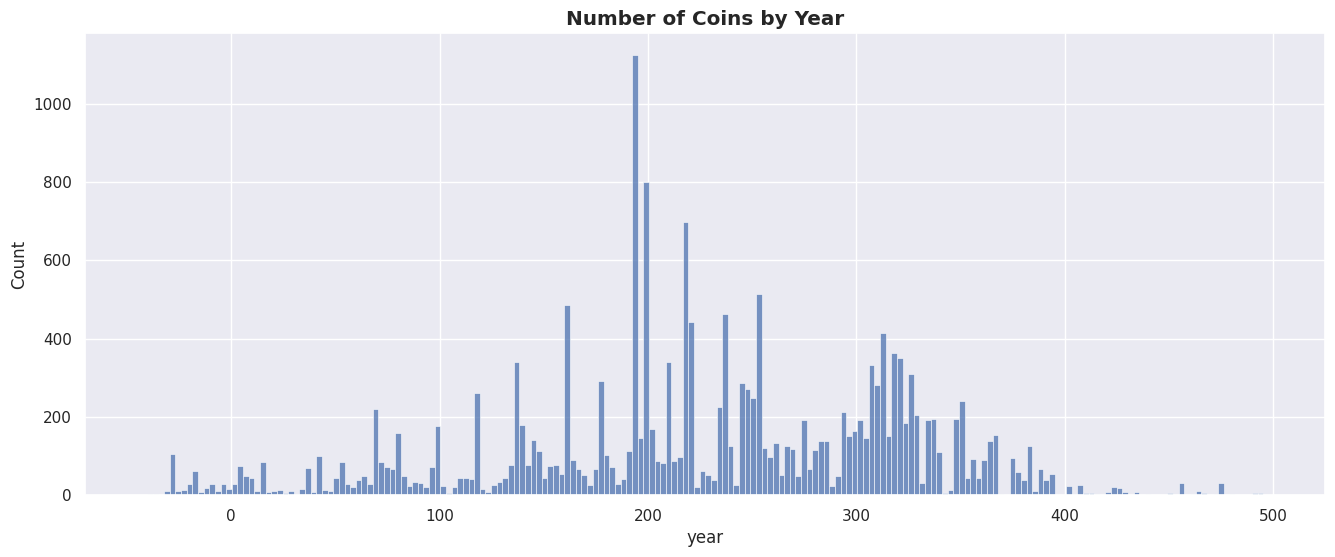

In [169]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(roman_coins_years, x='year', bins=200)
ax.set_title('Number of Coins by Year', fontdict={'weight': 'bold', 'size': 'large'})

<Axes: xlabel='year'>

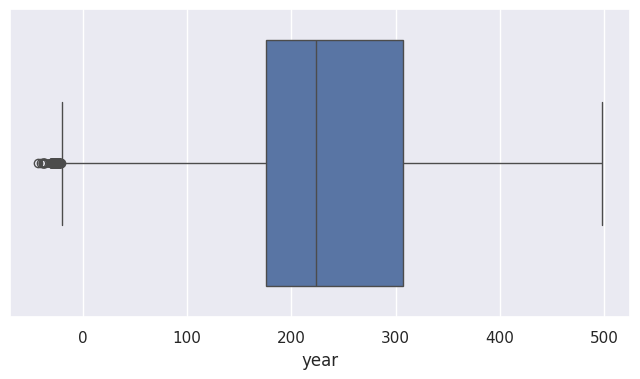

In [170]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(roman_coins_years, x='year')

#### Create a filtered dataset for coins with 'mass' values

In [171]:
roman_coins_mass = roman_coins.dropna(subset=['metal', 'mass'])
pd.to_numeric(roman_coins_mass['mass']).describe(percentiles=[.001, .01, .05, .25, .5, .75, .95, .99, .999])

count    8882.000000
mean       10.776165
std        14.270978
min         0.000000
0.1%        0.598810
1%          1.220000
5%          2.180500
25%         4.152500
50%         7.880000
75%        13.590000
95%        26.600000
99%        53.467500
99.9%      89.000000
max       970.000000
Name: mass, dtype: float64

Remove coins that fall outside the first and last tenths of a percentile

In [172]:
roman_coins_mass = roman_coins_mass.query('mass>.6 and mass<66')
pd.to_numeric(roman_coins_mass['mass']).describe()

count    8821.000000
mean       10.300474
std         8.599349
min         0.670000
25%         4.150000
50%         7.850000
75%        13.490000
max        65.920000
Name: mass, dtype: float64

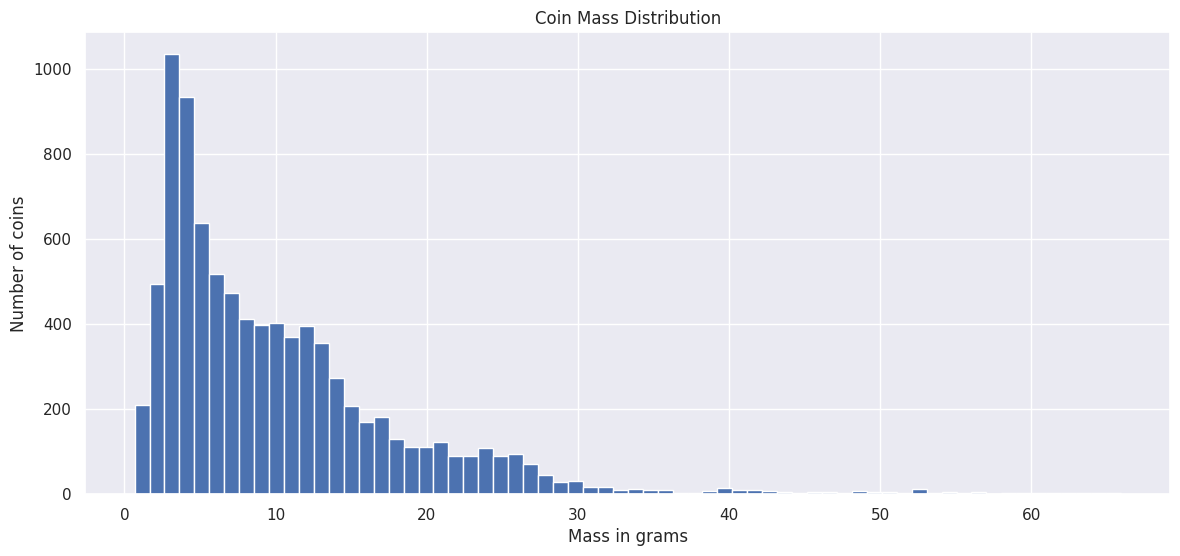

In [173]:
plt.figure(figsize=(14, 6))
plt.hist(x=roman_coins_mass['mass'], bins=66)
plt.title('Coin Mass Distribution'); plt.xlabel('Mass in grams'); plt.ylabel('Number of coins')
plt.show()

In [174]:
roman_coins_metals = roman_coins_raw.copy()
roman_coins_metals.dropna(subset='metal', inplace=True)
roman_coins_metals = roman_coins_metals[roman_coins_metals['metal'] != 'FAKE'].reset_index()
roman_coins_metals['era'].fillna('None')
metal_categories = ['Brass', 'Copper', 'Silver', 'Gold']
era_categories = ['None', 'BC', 'AD']
roman_coins_metals['metal'] = pd.Categorical(roman_coins_metals['metal'], categories=metal_categories, ordered=True)
roman_coins_metals['era'] = pd.Categorical(roman_coins_metals['era'], categories=era_categories, ordered=True)
roman_coins_metals['mass'] = roman_coins_metals['mass'].astype('float64')
roman_coins_metals['diameter'] = roman_coins_metals['diameter'].astype('float64')
roman_coins_metals['year'] = roman_coins_metals['year'].astype('float64')
roman_coins_metals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40402 entries, 0 to 40401
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         40402 non-null  int64   
 1   title         40402 non-null  object  
 2   id            38116 non-null  object  
 3   metal         40402 non-null  category
 4   mass          9876 non-null   float64 
 5   diameter      5470 non-null   float64 
 6   era           23543 non-null  category
 7   year          23435 non-null  float64 
 8   inscriptions  17482 non-null  object  
 9   txt           38113 non-null  object  
dtypes: category(2), float64(3), int64(1), object(4)
memory usage: 2.5+ MB


<Axes: ylabel='mass'>

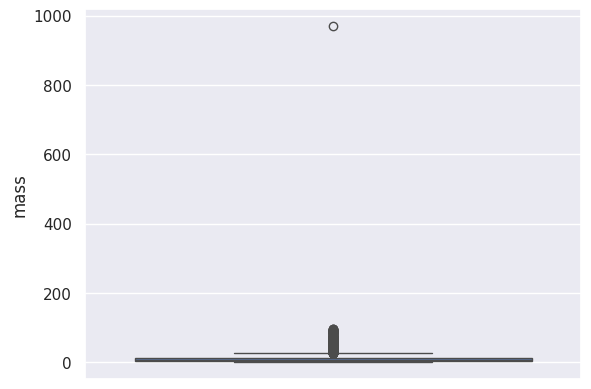

In [175]:
sns.boxplot(roman_coins_metals['mass'])

In [176]:
mass_percentile_25 = roman_coins_metals['mass'].quantile(0.25)
mass_percentile_75 = roman_coins_metals['mass'].quantile(0.75)
mass_iqr = mass_percentile_75 - mass_percentile_25
upper_limit = mass_percentile_75 + 1.5 * mass_iqr
lower_limit = mass_percentile_25 - 1.5 * mass_iqr
print('lower limit', lower_limit, 'upper limit:', upper_limit)

lower limit -10.25 upper limit: 27.75


#### Since lower limit is negative, we can ignore the lower limit and simply set an upper limit

In [177]:
roman_coins_metals = roman_coins_metals[roman_coins_metals['mass'] < 26.6].reset_index()
roman_coins_metals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9385 entries, 0 to 9384
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   level_0       9385 non-null   int64   
 1   index         9385 non-null   int64   
 2   title         9385 non-null   object  
 3   id            9344 non-null   object  
 4   metal         9385 non-null   category
 5   mass          9385 non-null   float64 
 6   diameter      2624 non-null   float64 
 7   era           7432 non-null   category
 8   year          7390 non-null   float64 
 9   inscriptions  3046 non-null   object  
 10  txt           9343 non-null   object  
dtypes: category(2), float64(3), int64(2), object(4)
memory usage: 678.7+ KB


/tmp/ipykernel_46697/3989482392.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = roman_coins_metals.groupby('metal')


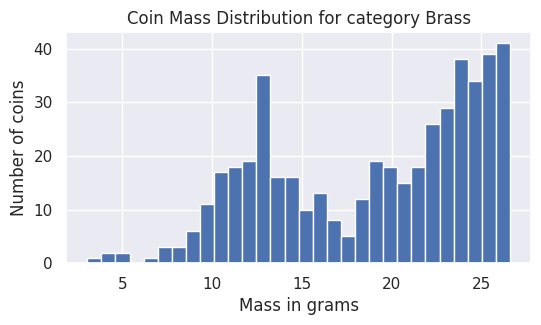

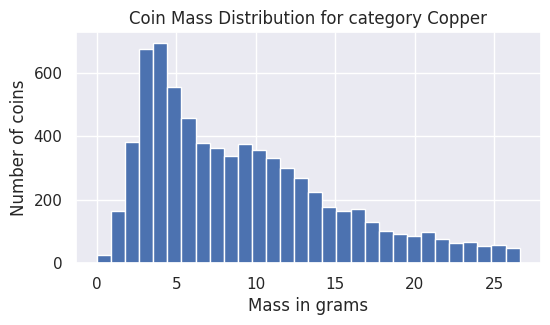

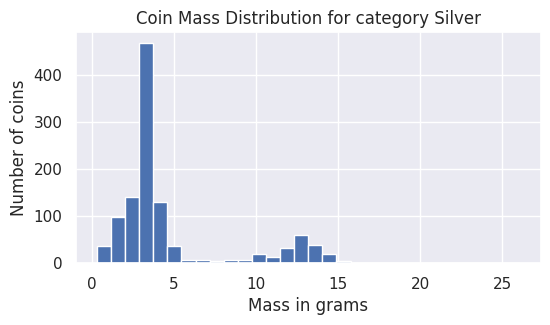

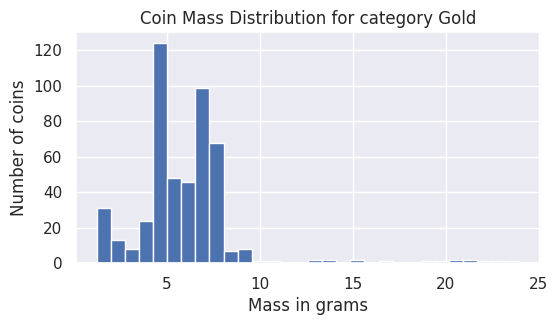

In [178]:

grouped = roman_coins_metals.groupby('metal')

for name, group in grouped:
    plt.figure(figsize=(6, 3))
    plt.hist(x=group['mass'], bins=30)
    plt.title(f'Coin Mass Distribution for category {name}')
    plt.xlabel('Mass in grams')
    plt.ylabel('Number of coins')
    plt.show()

#### Check distribution of the (limited) diameter values

In [179]:
pd.to_numeric(roman_coins['diameter'].dropna()).describe(percentiles=[.001, .01, .05, .25, .5, .75, .95, .99, .999])

count    4927.000000
mean       23.493450
std         6.721918
min         0.000000
0.1%        2.926000
1%         11.000000
5%         15.000000
25%        19.000000
50%        23.000000
75%        27.000000
95%        34.070000
99%        40.000000
99.9%      50.000000
max       198.000000
Name: diameter, dtype: float64

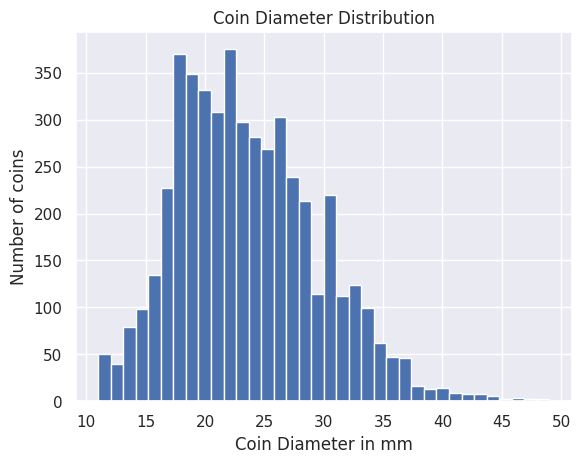

In [180]:
plt.hist(x=roman_coins.query("diameter > 10 and diameter < 50")['diameter'].dropna(), bins=36)
plt.title('Coin Diameter Distribution'); plt.xlabel('Coin Diameter in mm'); plt.ylabel('Number of coins')
plt.show()

#### Precursory glance at the correlation between mass and diameter, grouped by metal

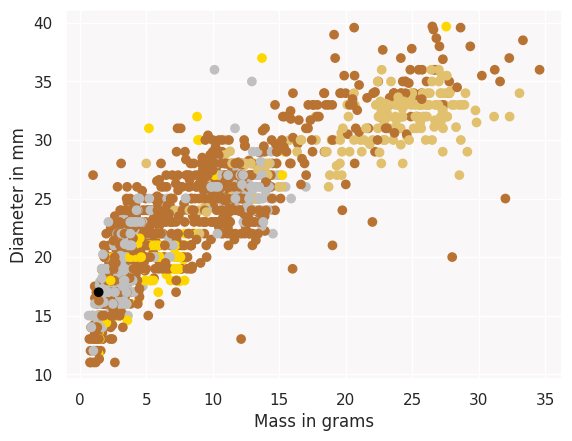

In [181]:
mass_diameter = roman_coins_mass.query("diameter > 10 and diameter < 40 and mass < 35").dropna(subset=['metal', 'diameter'])
colors = {'Gold':'gold', 'Copper':'#B87333', 'Silver':'silver', 'Brass':'#E1C16E', 'FAKE':'black'}
ax = plt.axes(); ax.set_facecolor('#F9F7F8')
plt.scatter(x=mass_diameter['mass'], y=mass_diameter['diameter'], c=mass_diameter['metal'].map(colors))
plt.xlabel('Mass in grams'); plt.ylabel('Diameter in mm')
plt.show()